In [3]:
import cv2
import numpy as np
from PIL import Image
np.set_printoptions(threshold=np.inf)
from torchvision import transforms

In [14]:
# %load '../Models/normalize.py'
import os
import sys
import argparse
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import torch

'''
Fits the training to a Scaler. Scaler can be Standard or MinMax.
When used as a Pytorch Transform, the call funciton transforms the image
and returns the transformed image and label.
'''
class Scaler(object):
    def __init__(self, root_dir, train_csv, resize, scaler= "std"):
        if scaler == "minmax":
            self.online_scaler = MinMaxScaler()
        elif scaler == "std":
            self.online_scaler = StandardScaler()
        elif scaler == "robust":
            self.online_scaler = RobustScaler()

        self.root_dir = root_dir
        self.train_csv = train_csv
        self.resize = resize
        # fit training data
        self.fit_data(self.train_csv, self.root_dir, self.online_scaler)
    
    def __call__(self, image):
        img = np.asarray(image, dtype=np.float)
        x, y = img.shape
        img = img.reshape(1, x * y)
        img = self.online_scaler.transform(img)
        img = img.reshape(x, y, 1)
        img = np.uint8(img*255)
        img = np.clip(img, 0, 255)

        return img

    def fit_data(self, csv_path, root_dir, online_scaler):
        print("======> fitting training data")
        csv_data = pd.read_csv(self.train_csv)
        for row in csv_data.itertuples():
            img_name = os.path.join(self.root_dir, row[1])
            image = Image.open(img_name)
            image = image.resize((self.resize, self.resize))
            image = np.asarray(image, dtype= np.float)
            x, y = image.shape
            image = image.reshape(1, x*y)
            self.online_scaler.partial_fit(image)

    # function modifies original data parameter to save memory
    def save_images(self, path, data, label):
        print("======> saving data")
        data = data.reshape((nsamples, 224, 224))
        for im, img_name, label in zip(data, label):
            if not os.path.exists(path + str(label)):
                os.makedirs(path + str(label))
            im = Image.fromarray(np.uint8(im*255)) # multiply to 255 to save image so the image can be used by ToTensor() in pytorch
            im.save(os.path.join(path, label, img_name))

class RunningStats:

    def __init__(self, resize= (240,240)):
        self.n = 0
        self.old_m = 0
        self.new_m = 0
        self.old_s = 0
        self.new_s = 0
        self.resize = resize

    def clear(self):
        self.n = 0

    def push(self, x):
        self.n += 1
        
        image = Image.open(x)
        image = image.resize(self.resize)
        image = np.asarray(image)
        image = image.reshape(1, self.resize[0] * self.resize[1])
#         print(image)

        if self.n == 1:
            self.old_m = self.new_m = np.mean(image)
            self.old_s = 0
        else:
            self.new_m = self.old_m + (np.mean(image) - self.old_m) / self.n
            self.new_s = self.old_s + (np.std(image) - self.old_m) * (np.std(image) - self.new_m)

            self.old_m = self.new_m
            self.old_s = self.new_s

    def mean(self):
        return self.new_m if self.n else 0.0

    def variance(self):
        return self.new_s / (self.n - 1) if self.n > 1 else 0.0

    def standard_deviation(self):
        return np.sqrt(self.variance())

'''
Casts a numpy array to torch tensor
'''
class CastTensor(object):
    def __init__(self, dtype):
        self.type = dtype

    def __call__(self, image):
        img = torch.from_numpy(image.transpose((2, 0, 1)))
        # img = image.type(self.type)

        return img

'''
Shifts the image by s and t.
The shifting matrix has dimensions 2x3 Ex: [[1, 0, s], [0, 1, t]], where s and t are the shifting constants
and the array is an np.float32
'''
class TranslateImage(object):
    def __init__(self, s, t, random= False):
        self.s = s
        self.t = t
        self.random = random

    def __call__(self, img):
        shift = np.float32([[1, 0, self.s], [0, 1, self.t]])
        if self.random:
            shift[0,2] = np.random.randint(-self.s, self.s+1)

        translated_img = np.array(img, dtype= np.float)
        rows, cols, chan  = translated_img.shape
        translated_img = cv2.warpAffine(translated_img, shift, (cols, rows))
        translated_img = translated_img.reshape((cols, rows, chan))

        return translated_img

'''
Performs a periodic shift of the image. Meaning that the image is shifted over by shift 
but the pixels wrap around so they are not lost.
'''
class PeriodicShift(object):
    def __init__(self, shift, random= False):
        self.shift = shift
        self.random = random

    def __call__(self, img):
        s = self.shift
        if self.random:
            s = np.random.randint(-self.shift, self.shift+1)

        img_array = np.array(img, dtype=np.float)
        rolled_img = np.roll(img_array, shift= s, axis=1)

        return rolled_img

# class Defocus(network, batch_size, device, test_csv, root_dir):

'''
Adds bias noise to the input image.
The bias is added when the object is called
'''
class BiasNoise(object):
    def __init__(self, bias_noise, random= False):
        self.bias_noise = bias_noise
        self.random = random

    def __call__(self, img):
        bn = self.bias_noise
        if self.random:
            bn = np.randm.randint(-self.bias_noise, self.bias_noise+1)

        noisy_img = np.array(img, dtype= np.float) + bn
        rows, cols, chan = noisy_img.shape
        noisy_img = noisy_img.reshape((cols, rows, chan))
        noisy_img_clipped = np.clip(noisy_img, 0, 255)  # we might get out of bounds due to noise

        return noisy_img_clipped

'''
Adds Gaussian Noise to the image with mean and std.
The bias is added when the object is called
'''
class GaussianNoise(object):
    def __init__(self, std, mean=0):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        noisy_img = np.array(img, dtype= np.float)
        rows, cols, chan = noisy_img.shape
        noisy_img = noisy_img + np.random.normal(self.mean, self.std, noisy_img.shape)
        noisy_img = noisy_img.reshape((cols, rows, chan))
        noisy_img_clipped = np.clip(noisy_img, 0, 255)  # we might get out of bounds due to noise

        return noisy_img_clipped

class MaxNormalization(object):
    def __init__(self, max_val):
        self.max = max_val

    def __call__(self, img):
        norm_img = np.array(img, dtype= np.float) * self.max
        rows, cols = norm_img.shape
        norm_img = norm_img.reshape((cols, rows, 1))

        return norm_img


In [18]:
img = Image.open('5400.png')
ndarray = np.array(img, dtype=np.float)
m = MaxNormalization(.003)
c = CastTensor('')
ndarray = m(ndarray)
c(ndarray).type()

'torch.DoubleTensor'

In [16]:
data_transforms = []
data_transforms += [BiasNoise(50)]
data_transforms += [TranslateImage(np.float32([[1, 0, 0], [0, 1, 0]]))]
# data_transforms += [GaussianNoise(30)]

images = []

for d_transform in data_transforms:
    data_transform = transforms.Compose([
        transforms.Resize((240, 240)),
        MaxNormalization(0.0038910505836575876),
        d_transform,
        transforms.ToTensor(),
#         CastTensor('torch.FloatTensor'),
#         transforms.Normalize([157.11056947927852], [139.749640327443])
        ])
    images.append(data_transform(img))

TypeError: __init__() missing 1 required positional argument: 't'

In [91]:
len(images)

2

In [92]:
print(np.array(images[0], dtype=np.float))

[[[0.82182044 0.80004579 0.77593654 0.75620663 0.73871976 0.72190434
   0.79235524 0.75631344 0.74634928 0.75379568 0.76635385 0.71978337
   0.71506828 0.77891207 0.70397502 0.78492409 0.73963535 0.70704204
   0.70626384 0.68380255 0.76429391 0.74596781 0.74209201 0.72497141
   0.73911649 0.77538723 0.72530711 0.69364464 0.69274437 0.71305412
   0.78410012 0.74413675 0.74505228 0.73336387 0.72462046 0.68897539
   0.70542461 0.75559628 0.7060197  0.73380637 0.76942092 0.7399863
   0.7628901  0.74279392 0.7455253  0.72025639 0.73559171 0.77238119
   0.75785458 0.7527886  0.73015946 0.76215762 0.73785001 0.76292062
   0.75777829 0.70226598 0.73151755 0.68599987 0.68763256 0.74308383
   0.71982914 0.69773406 0.69370568 0.72574961 0.69909209 0.70766765
   0.73829252 0.71197075 0.75609982 0.7215839  0.67324334 0.72864884
   0.73067826 0.68798351 0.74140537 0.72910661 0.73968112 0.73275352
   0.73295188 0.73528647 0.75735104 0.71654844 0.75976199 0.71581602
   0.67815673 0.69561303 0.71992069

In [84]:
imgs = []
pil = transforms.ToPILImage()
for image in images: 
    imgs.append(pil(image))


In [85]:
# for img in imgs:
#     img.show()

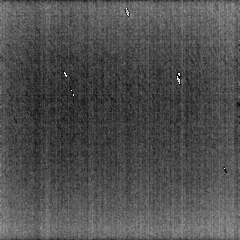

In [86]:
imgs[0]

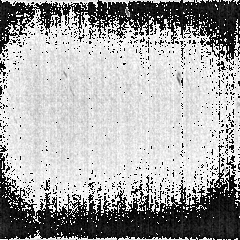

In [87]:
imgs[1]

In [78]:
imgs[2]

IndexError: list index out of range